In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline

import os
import sys
from pathlib import Path
from pprint import pprint

from analysis import analysis # this works because same package
from utils import utils # sibling package...

In [6]:
def get_experiment_data_folder(experiment):
    if sys.platform == "linux":
        base_data_folder = Path("/mnt/c/Users/spencer/data/")
    else:
        base_data_folder = Path("/Users/spencerw/data/")
    experiment_data_folder = base_data_folder / experiment
    assert experiment_data_folder.exists(
    ), f"Path {experiment_data_folder} not found"

    return experiment_data_folder

def build_path_dictionary(experiment):
    data_folder = get_experiment_data_folder(experiment)
    subjects = [x.name for x in data_folder.iterdir() if x.name[0] != "."]
    path_dictionary = {}
    for subject in subjects:
        subject_folder = data_folder / subject
        path_dictionary.update({subject:{}})
        path_dictionary[subject].update({"path" : subject_folder})
        tasks = [x.name for x in subject_folder.iterdir() if x.name[0] != "."]
        path_dictionary[subject].update({"tasks": {}})
        for task in tasks:
            path_dictionary[subject]["tasks"].update({task : {"path" : subject_folder/task}})
            sessions = [x.name for x in (subject_folder/task).iterdir() if x.name[0] != "."]
            path_dictionary[subject]["tasks"][task].update({"sessions" : [x for x in (subject_folder/task).iterdir() if x.name[0] != "."]})
    return path_dictionary

def last_element(thing):
    return str(thing)[-1]

def plot_preprocessing(data, channel, ax):
    N = data.shape[1]
    T = N*0.0005
    times = np.linspace(0,T,N)
    print(f"trial time: {T}")
    print(times[:10])
    data = data[channel,:]
    data_hp = analysis.highpass(data, cutoff=3)
    data_abs = analysis.rectify(data_hp)
    data_lp = analysis.lowpass(data_abs, cutoff=20)
    ax.plot(times, data,'k')
    ax.plot(times, data_hp,'r')
    ax.plot(times, data_abs,'g')
    ax.plot(times, data_lp,'b')

def parse_filename_prefix(x):
    name = x.name
    prefix = name[:2]
    if prefix[-1] == "_":
        return int(prefix[0])
    else:
        return int(prefix)

In [7]:
experiment = "self_test_8_31_21"
num_channels = 64
path_dictionary = build_path_dictionary(experiment)
# pprint(path_dictionary)

## Natural Movement

In [31]:

subject = "simon"
task = "natural_movement"
session = 0

session_path_list = sorted(path_dictionary[subject]["tasks"][task]["sessions"],key=last_element)
print(session_path_list)
session_path = session_path_list[session]
session_data_paths = sorted([x for x in session_path.iterdir() if x.suffix==".bin"],key=str)
session_cue_paths = sorted([x for x in session_path.iterdir() if x.suffix==".csv"],key=str)
data_path = session_data_paths[-1]
print(data_path)
cue_path = session_cue_paths[-1]
print(cue_path)

[PosixPath('/Users/spencerw/data/self_test_8_31_21/simon/natural_movement/session_0')]
/Users/spencerw/data/self_test_8_31_21/simon/natural_movement/session_0/wrist up_2021_08_31_16_30.bin
/Users/spencerw/data/self_test_8_31_21/simon/natural_movement/session_0/wrist up_cue_2021-08-31T16_30_40.csv


In [37]:

cue = np.genfromtxt(str(cue_path), delimiter=',', skip_header=1)
data = analysis.load_bin_file(data_path).reshape(-1,num_channels+4).T

trial time: 9.0
[0.         0.00050003 0.00100006 0.00150008 0.00200011 0.00250014
 0.00300017 0.00350019 0.00400022 0.00450025]


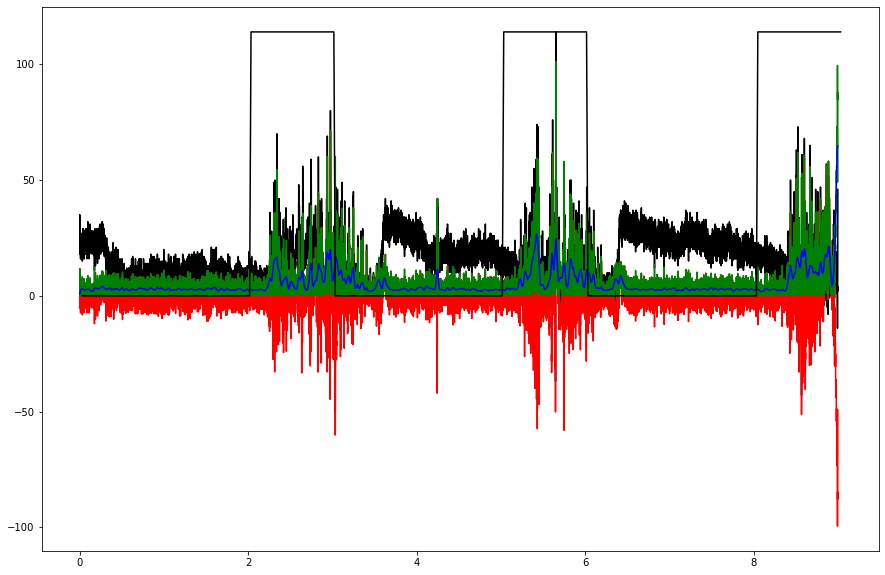

In [45]:
c = 11

fig, ax = plt.subplots(1,1,figsize=(15,10))
plot_preprocessing(data, c, ax)

m = np.max(data[c])
ax.plot(cue[:,0],m*cue[:,2], "k")

## Calibrations Bars

In [42]:
subject = "miranda"
task = "calibration_bars"
session = 1

session_path_list = sorted(path_dictionary[subject]["tasks"][task]["sessions"],key=lambda x: str(x)[-1])
session_path = session_path_list[session]


bar_order_path = [x for x in session_path.iterdir() if x.suffix == ".csv"][0]
print(bar_order_path)  
session_emg_paths = sorted([x for x in session_path.iterdir() if "V" not in x.name and x.suffix != ".csv"], key=parse_bar_filename)
session_bar_paths = sorted([x for x in session_path.iterdir() if "V" in x.name and x.suffix != ".csv"], key=parse_bar_filename)
emg_path = session_emg_paths[-1]
bar_path = session_bar_paths[-1]
print(emg_path)
print(bar_path)

/Users/spencerw/data/self_test_8_26_21/miranda/calibration_bars/session_1/bar_order_2021-08-26T16_44_41.csv
/Users/spencerw/data/self_test_8_26_21/miranda/calibration_bars/session_1/63_2021_08_26_16_59.bin
/Users/spencerw/data/self_test_8_26_21/miranda/calibration_bars/session_1/63_V_2021_08_26_16_59.bin


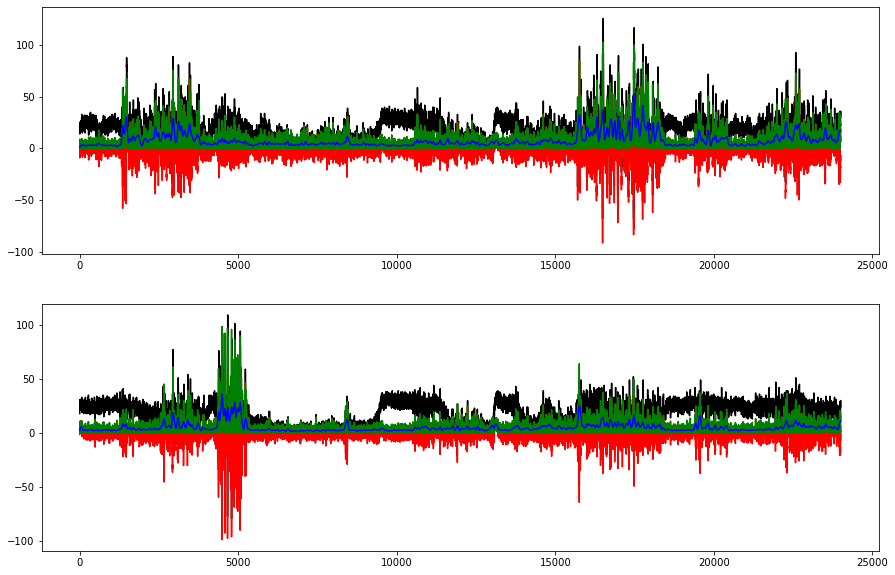

In [37]:
emg = analysis.load_bin_file(emg_path).reshape(-1,num_channels+4).T
fig, axes = plt.subplots(2,1,figsize=(15,10))
plot_preprocessing(emg, 35, axes[0])
plot_preprocessing(emg, 4, axes[1])

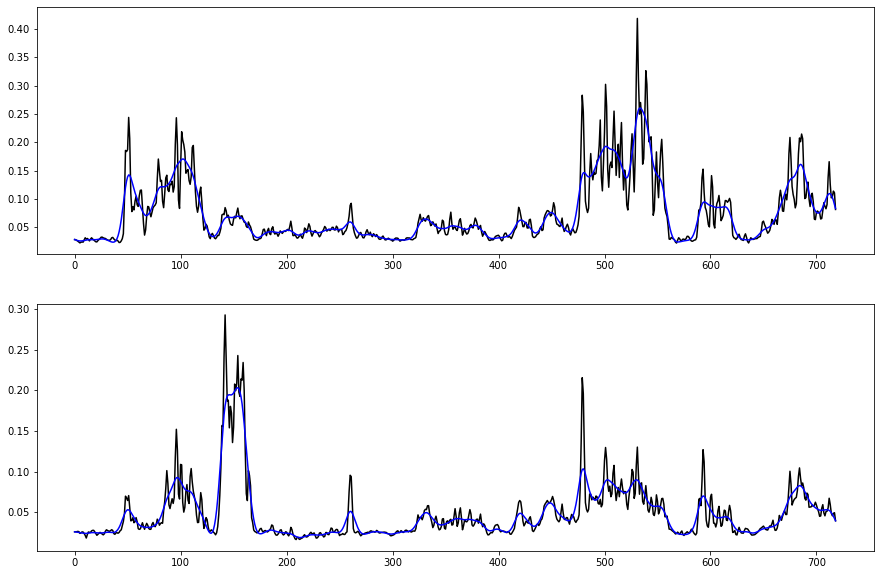

In [38]:
bar = np.fromfile(bar_path,dtype=np.float32).reshape(-1,num_channels).T
fig, axes = plt.subplots(2,1,figsize=(15,10))
axes[0].plot(bar[35],"k")
axes[0].plot(analysis.lowpass(bar[35],cutoff=100),"b")
axes[1].plot(bar[4],"k")
axes[1].plot(analysis.lowpass(bar[4],cutoff=100),"b")

- height of target bar vs height of other bars? (some type of score)
- "shape" of bar data overall? 
  - dimensionality
  - ...?
- search strategy (dynamical mode?)
- 

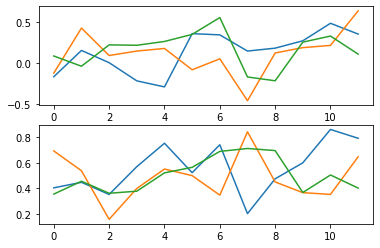

In [75]:
subject = "miranda"
task = "center_hold"
session = 0

fig,axes = plt.subplots(2,1)

session_path_list = sorted(path_dictionary[subject]["tasks"][task]["sessions"],key=lambda x: str(x)[-1])
for i, session_path in enumerate(session_path_list):
    session_filtered_emg_paths = sorted([x for x in session_path.iterdir() if "filtered" in x.name and x.suffix != ".csv"],key=parse_filename_prefix)
    emg_path = session_emg_paths[0]

    session_behavior_paths = sorted([x for x in session_path.iterdir() if "behavior" in x.name],key=parse_filename_prefix)
    vars = []
    means = []
    for i, path in enumerate(session_behavior_paths):
        behavior_path = session_behavior_paths[i]
        behavior = np.genfromtxt(str(behavior_path), delimiter=',', skip_header=1)
        cursorx = behavior[:,-2]
        cursory = behavior[:,-1]
        vars.append(np.std(cursorx)+np.std(cursory))
        means.append(np.mean(cursorx)+np.mean(cursory))
    axes[1].plot(vars)
    axes[0].plot(means)

['Hit' 'Miss' 'No Hold']
['Hit' 'Miss' 'No Hold']
['Hit' 'Miss' 'No Hold']


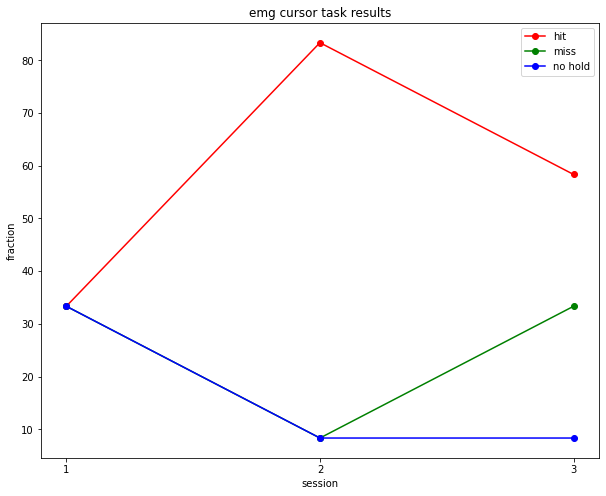

In [135]:
hits = []
misses = []
noholds = []
for i, behavior_path in enumerate(session_path_list):
    outcome_path = [x for x in behavior_path.iterdir() if "result" in x.name][0]
    behavior = np.genfromtxt(str(outcome_path), delimiter=',', skip_header=1, dtype=None, encoding=None)
    outcomes = [x[0] for x in behavior]
    uniques, counts = np.unique(outcomes, return_counts=True)
    print(uniques)
    hits.append(counts[0])
    misses.append(counts[1])
    noholds.append(counts[2])
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot([h*(100/12) for h in hits] , "r-o", label="hit")
ax.plot([m*(100/12) for m in misses] , "g-o", label="miss")
ax.plot([n*(100/12) for n in noholds] , "b-o", label="no hold")
ax.set_xticks([0,1,2])
ax.set_xticklabels([1,2,3])
ax.set_xlabel("session")
ax.set_ylabel("fraction")
ax.set_title("emg cursor task results")
ax.legend()